# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cv2
import os, fnmatch
from tqdm.auto import tqdm
import seaborn as sns

# Para trabajar con ResNet
from torchvision.models import resnet50
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import copy
import random
from   torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import gc
import shutil

# Métricas
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

#Para manipular .rar
import zipfile

# Geopandas
import geopandas as gpd
import networkx as nx
import collections

from tqdm import tqdm
from tqdm.notebook import tqdm
from collections import defaultdict

plt.style.use('ggplot')

c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Open street maps
!pip install -q osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.2 MB/s eta 0:00:00


In [2]:
import osmnx as ox
ox.config(use_cache=True, log_console=True)

C:\Users\Bruno\AppData\Local\Temp\ipykernel_20044\4194810668.py:2: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


In [ ]:
!pip install -q torch_geometric

In [3]:
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
from torch_geometric.transforms import FeaturePropagation

In [ ]:
!pip install gdown

In [ ]:
import gdown

# ID del archivo de Google Drive
file_id = '1AvxGaBQj02E_ZWWTt3_ATY0uK4VMLH9u'
# URL de descarga directa
url = f'https://drive.google.com/uc?id={file_id}'
# Nombre del archivo que deseas guardar
output = 'imagenes_stgo.zip'  # Cambia la extensión según el archivo

gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1AvxGaBQj02E_ZWWTt3_ATY0uK4VMLH9u
From (redirected): https://drive.google.com/uc?id=1AvxGaBQj02E_ZWWTt3_ATY0uK4VMLH9u&confirm=t&uuid=abecfdbb-b24e-4bea-b556-faeea60f663e
To: /content/imagenes_stgo.zip
100%|██████████| 4.07G/4.07G [00:52<00:00, 77.4MB/s]


'imagenes_stgo.zip'

# Fotografías de Santiago

In [4]:
dir_rar = "content/imagenes_stgo.zip"

Nombre foto 1: imagenes_stgo/-33.36865132,-70.704327184.jpg


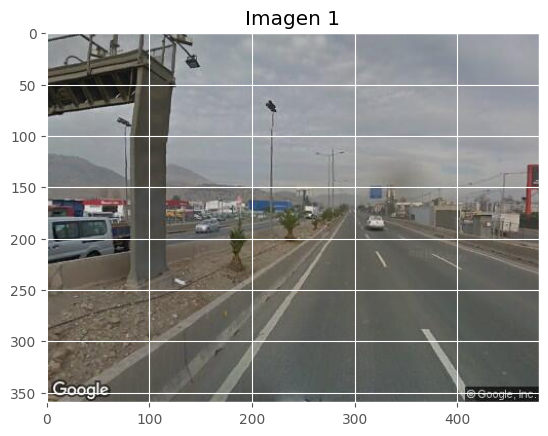

In [5]:
# Definir coordienada latitud y longitud
ejemplo = "imagenes_stgo/-33.36865132,-70.704327184.jpg"
try:
    with zipfile.ZipFile(dir_rar, 'r') as archivo:
        archivo_contents = archivo.namelist() # almacena lista con todos los nombres de las imágenes
        if ejemplo in archivo_contents:
            archivo.extract(ejemplo)
            print(f"Nombre foto 1: {ejemplo}")
        else:
            print(f"Error")

except FileNotFoundError as e:
    print(f"Error: {e}")

img1 = cv2.imread(ejemplo) # cambiar a f"/content/{ejemplo}" si se ejecuta en colab
I1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # Formato imread a formato plt

plt.imshow(I1)
plt.title("Imagen 1")

plt.show()

In [6]:
df_fotos_rar = pd.DataFrame({"nombre_foto": archivo_contents})
print(len(df_fotos_rar))

df_fotos_rar.head()

125921


,nombre_foto
0,imagenes_stgo/
1,"imagenes_stgo/-33.323944,-70.51263428391167.jpg"
2,"imagenes_stgo/-33.323944,-70.5127291.jpg"
3,"imagenes_stgo/-33.323944,-70.51298714285714.jpg"
4,"imagenes_stgo/-33.323944,-70.513436104.jpg"


In [7]:
df_fotos = df_fotos_rar.iloc[1:].reset_index(drop=True)
df_fotos_filtro = df_fotos[df_fotos.nombre_foto.str.contains(".jpg")].reset_index(drop=True)

print(len(df_fotos))
df_fotos.head()

125920


,nombre_foto
0,"imagenes_stgo/-33.323944,-70.51263428391167.jpg"
1,"imagenes_stgo/-33.323944,-70.5127291.jpg"
2,"imagenes_stgo/-33.323944,-70.51298714285714.jpg"
3,"imagenes_stgo/-33.323944,-70.513436104.jpg"
4,"imagenes_stgo/-33.323944,-70.51379769565217.jpg"



En la siguiente función se crearán las columnas latitud y longitud que será necesario para seleccionar puntos en la comuna

In [8]:
def lat_lon(x):
  x = str(x)
  x = x.replace("imagenes_stgo/","")
  x = x.replace(".jpg","")
  latitud, longitud = x.split(",")
  if " " in longitud:
    longitud, _ = longitud.split(" ")
  return latitud, longitud

In [9]:
latitud_list = []
longitud_list = []
for i in df_fotos_filtro.nombre_foto.tolist():
  a, b = lat_lon(i)
  latitud_list.append(a)
  longitud_list.append(b)

In [10]:
df_fotos_filtro["latitud"] = latitud_list
df_fotos_filtro["longitud"] = longitud_list

df_fotos_filtro["latitud"] = df_fotos_filtro["latitud"].astype(float)
df_fotos_filtro["longitud"] = df_fotos_filtro["longitud"].astype(float)

In [11]:
df_fotos_filtro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125380 entries, 0 to 125379
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   nombre_foto  125380 non-null  object 
 1   latitud      125380 non-null  float64
 2   longitud     125380 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.9+ MB


In [12]:
df_fotos_filtro

,nombre_foto,latitud,longitud
0,"imagenes_stgo/-33.323944,-70.51263428391167.jpg",-33.323944,-70.512634
1,"imagenes_stgo/-33.323944,-70.5127291.jpg",-33.323944,-70.512729
2,"imagenes_stgo/-33.323944,-70.51298714285714.jpg",-33.323944,-70.512987
3,"imagenes_stgo/-33.323944,-70.513436104.jpg",-33.323944,-70.513436
4,"imagenes_stgo/-33.323944,-70.51379769565217.jpg",-33.323944,-70.513798
...,...,...,...
125375,"imagenes_stgo/-33.67884090851735,-70.680595141...",-33.678841,-70.680595
125376,"imagenes_stgo/-33.67884090851735,-70.699120236...",-33.678841,-70.699120
125377,"imagenes_stgo/-33.67884090851735,-70.706530274...",-33.678841,-70.706530
125378,"imagenes_stgo/-33.67884090851735,-70.717645331...",-33.678841,-70.717645


A continuación, se crea la columna geometry.

In [13]:
allpoints = gpd.GeoDataFrame(df_fotos_filtro, geometry=gpd.points_from_xy(df_fotos_filtro["longitud"], df_fotos_filtro["latitud"], crs="EPSG:4326"))

allpoints

,nombre_foto,latitud,longitud,geometry
0,"imagenes_stgo/-33.323944,-70.51263428391167.jpg",-33.323944,-70.512634,POINT (-70.51263 -33.32394)
1,"imagenes_stgo/-33.323944,-70.5127291.jpg",-33.323944,-70.512729,POINT (-70.51273 -33.32394)
2,"imagenes_stgo/-33.323944,-70.51298714285714.jpg",-33.323944,-70.512987,POINT (-70.51299 -33.32394)
3,"imagenes_stgo/-33.323944,-70.513436104.jpg",-33.323944,-70.513436,POINT (-70.51344 -33.32394)
4,"imagenes_stgo/-33.323944,-70.51379769565217.jpg",-33.323944,-70.513798,POINT (-70.51380 -33.32394)
...,...,...,...,...
125375,"imagenes_stgo/-33.67884090851735,-70.680595141...",-33.678841,-70.680595,POINT (-70.68060 -33.67884)
125376,"imagenes_stgo/-33.67884090851735,-70.699120236...",-33.678841,-70.699120,POINT (-70.69912 -33.67884)
125377,"imagenes_stgo/-33.67884090851735,-70.706530274...",-33.678841,-70.706530,POINT (-70.70653 -33.67884)
125378,"imagenes_stgo/-33.67884090851735,-70.717645331...",-33.678841,-70.717645,POINT (-70.71765 -33.67884)


# Cargar datos de delitos

In [ ]:
!gdown https://drive.google.com/uc?id=1Bki6zuVe3d32YAHS0FGjO4SlNHP7WzKl

Downloading...
From (original): https://drive.google.com/uc?id=1Bki6zuVe3d32YAHS0FGjO4SlNHP7WzKl
From (redirected): https://drive.google.com/uc?id=1Bki6zuVe3d32YAHS0FGjO4SlNHP7WzKl&confirm=t&uuid=96f8d5c2-02be-4031-b928-75bbe35857d1
To: /content/delitos_limpio.csv
100% 879M/879M [00:09<00:00, 93.2MB/s]


In [14]:
import pandas as pd
import geopandas as gpd

csv_file_path = 'content/delitos_limpio.csv'
df = pd.read_csv(csv_file_path)

gdf_delitos = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs="EPSG:4326")

gdf_delitos

,index,x,y,parte_id,fecha,hora,rango,clasificacion_parte,source,source_glosa,...,delito,riesgo_situacional,descripcion_situacional,denuncia_formal,denuncia_informa,comuna,id_comuna,barrio,id_barrio,geometry
0,NaN,-70.946931,-33.458234,394474,2015-07-31,08:30:00,8:00-11:59,Denuncia,caso_policial,Caso policial,...,Robo vehículos motorizados,NaN,NaN,NaN,NaN,Pudahuel,13124,NaN,NaN,POINT (-70.94693 -33.45823)
1,NaN,-70.937412,-33.475248,12796554,2021-11-05,19:40:00,16:00-19:59,Denuncia,caso_policial,Caso policial,...,Hallazgo de vehículo,NaN,NaN,NaN,NaN,Pudahuel,13124,NaN,NaN,POINT (-70.93741 -33.47525)
2,NaN,-70.937002,-33.456887,148692,2016-05-02,11:40:00,8:00-11:59,Denuncia,caso_policial,Caso policial,...,Lesiones leves,NaN,NaN,NaN,NaN,Pudahuel,13124,NaN,NaN,POINT (-70.93700 -33.45689)
3,NaN,-70.937002,-33.456887,5022545,2017-08-05,06:30:00,4:00-7:59,Denuncia,caso_policial,Caso policial,...,Daños,NaN,NaN,NaN,NaN,Pudahuel,13124,NaN,NaN,POINT (-70.93700 -33.45689)
4,NaN,-70.936990,-33.475305,13108530,2022-01-07,22:05:00,20:00-23:59,Denuncia,caso_policial,Caso policial,...,Robo con violencia o intimidación,NaN,NaN,NaN,NaN,Pudahuel,13124,NaN,NaN,POINT (-70.93699 -33.47530)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4418603,NaN,-70.248616,-33.357852,12586668,2021-08-13,10:00:00,8:00-11:59,Denuncia,caso_policial,Caso policial,...,Robo en lugar habitado,NaN,NaN,NaN,NaN,Lo Barnechea,13115,NaN,NaN,POINT (-70.24862 -33.35785)
4418604,NaN,-70.248301,-33.352921,8866623,2019-09-18,03:40:00,0:00-3:59,Detención,caso_policial,Caso policial,...,Lesiones leves,NaN,NaN,NaN,NaN,Lo Barnechea,13115,NaN,NaN,POINT (-70.24830 -33.35292)
4418605,NaN,-70.248213,-33.353317,8866628,2019-09-21,18:35:00,16:00-19:59,Detención,caso_policial,Caso policial,...,Robo en lugar no habitado,NaN,NaN,NaN,NaN,Lo Barnechea,13115,NaN,NaN,POINT (-70.24821 -33.35332)
4418606,NaN,-70.212959,-33.249627,9829539,2020-01-11,10:00:00,8:00-11:59,Denuncia,caso_policial,Caso policial,...,Robo en lugar no habitado,NaN,NaN,NaN,NaN,Lo Barnechea,13115,NaN,NaN,POINT (-70.21296 -33.24963)


# Crear de grafo con Open Street Map

In [59]:
comunas = [
    "Santiago, Chile",
    "Conchalí, Chile",
    "Huechuraba, Chile",
    "Independencia, Chile",
    "Quilicura, Chile",
    "Recoleta, Chile",
    "Renca, Chile",
    "Las Condes, Chile",
    "Lo Barnechea, Chile",
    "Providencia, Chile",
    "Vitacura, Chile",
    "La Reina, Chile",
    "Macul, Chile",
    "Nunoa, Chile",
    "Penalolen, Chile",
    "La Florida, Chile",
    "La Granja, Chile",
    "El Bosque, Chile",
    "La Cisterna, Chile",
    "La Pintana, Chile",
    "San Ramon, Chile",
    "Lo Espejo, Chile",
    "Pedro Aguirre Cerda, Chile",
    # "San Joaquin, Chile", SJ No se encuentra en el mapa
    "San Miguel, Chile",
    "Cerrillos, Chile",
    "Estacion Central, Chile",
    "Maipu, Chile",
    "Cerro Navia, Chile",
    "Lo Prado, Chile",
    "Pudahuel, Chile",
    "Quinta Normal, Chile"
]

(SANTIAGO, CONCHALI, HUECHURABA, INDEPENDENCIA, QUILICURA, RECOLETA, RENCA, LAS_CONDES,
 LO_BARNECHEA, PROVIDENCIA, VITACURA, LA_REINA, MACUL, NUNOA, PENALOLEN, LA_FLORIDA, LA_GRANJA,
 EL_BOSQUE, LA_CISTERNA, LA_PINTANA, SAN_RAMON, LO_ESPEJO, PEDRO_AGUIRRE_CERDA, #SAN_JOAQUIN, SJ No se encuentra en el mapa
 SAN_MIGUEL, CERRILLOS, ESTACION_CENTRAL, MAIPU, CERRO_NAVIA, LO_PRADO, PUDAHUEL, QUINTA_NORMAL) = range(len(comunas))

# Crear un grafo y un gdf para cada comuna

graphs_comunas = []
gdfs_comunas = []
for i in range(len(comunas)):
    G = ox.graph_from_place(comunas[i], network_type='drive')
    graphs_comunas.append(G)
    gdf = ox.geocode_to_gdf(comunas[i])
    gdfs_comunas.append(gdf)

# Crear G como la unión de todos los grafos

G = nx.compose_all(graphs_comunas)

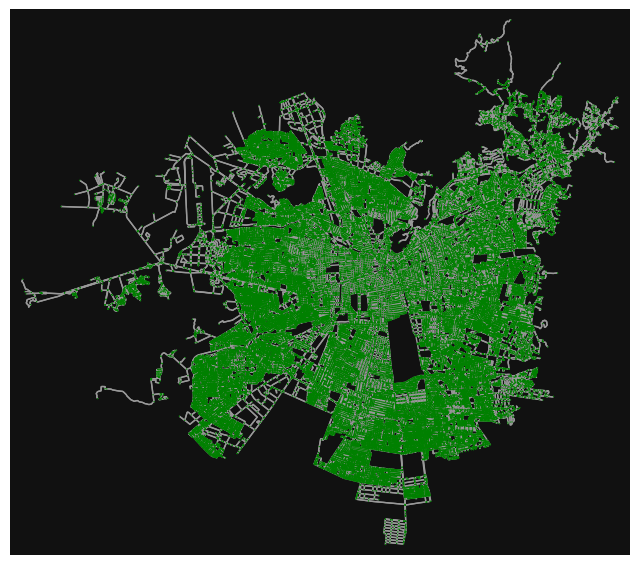

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [60]:
ox.plot_graph(G, node_color="green", node_size=1)

# Encontrar imágenes más cercanas

Ahora se encontrará el nodo más cercano a cada imagen. Este proceso toma 30 minutos, aproximadamente.

In [61]:
import osmnx as ox
from shapely.geometry import Point

def get_intersection(gdf, coords): # Recibe un gdf y retorna si un punto está dentro de la comuna
    geom = gdf.loc[0, 'geometry']

    # get the bounding box of the city
    geom.bounds

    # determine if a point is within the city boundary
    return geom.intersects(Point(coords))


In [62]:
def get_nearest_node(gdfs, graphs, coords): # Recibe una lista de gdfs y una lista de grafos y retorna el nodo más cercano
    for i in range(len(gdfs)):
        gdf = gdfs[i]
        if get_intersection(gdf, coords):
            graph = graphs[i]
            return ox.distance.nearest_nodes(graph, *coords)

In [63]:
allpoints["nearest_node"] = allpoints.geometry.apply(lambda point: get_nearest_node(gdfs_comunas, graphs_comunas, (point.x, point.y)) if not point.is_empty else None)

In [64]:
allpoints.nearest_node.value_counts()

nearest_node
5.246126e+09    85
1.378437e+09    77
6.077285e+09    74
1.240505e+09    70
1.384138e+09    51
                ..
4.440996e+09     1
1.617119e+09     1
2.598569e+09     1
2.801668e+08     1
3.762828e+08     1
Name: count, Length: 53504, dtype: int64

In [72]:
allpoints

,nombre_foto,latitud,longitud,geometry,nearest_node
0,"imagenes_stgo/-33.323944,-70.51263428391167.jpg",-33.323944,-70.512634,POINT (-70.51263 -33.32394),1.090646e+10
1,"imagenes_stgo/-33.323944,-70.5127291.jpg",-33.323944,-70.512729,POINT (-70.51273 -33.32394),1.090646e+10
2,"imagenes_stgo/-33.323944,-70.51298714285714.jpg",-33.323944,-70.512987,POINT (-70.51299 -33.32394),1.090646e+10
3,"imagenes_stgo/-33.323944,-70.513436104.jpg",-33.323944,-70.513436,POINT (-70.51344 -33.32394),1.090646e+10
4,"imagenes_stgo/-33.323944,-70.51379769565217.jpg",-33.323944,-70.513798,POINT (-70.51380 -33.32394),1.090646e+10
...,...,...,...,...,...
125375,"imagenes_stgo/-33.67884090851735,-70.680595141...",-33.678841,-70.680595,POINT (-70.68060 -33.67884),NaN
125376,"imagenes_stgo/-33.67884090851735,-70.699120236...",-33.678841,-70.699120,POINT (-70.69912 -33.67884),NaN
125377,"imagenes_stgo/-33.67884090851735,-70.706530274...",-33.678841,-70.706530,POINT (-70.70653 -33.67884),NaN
125378,"imagenes_stgo/-33.67884090851735,-70.717645331...",-33.678841,-70.717645,POINT (-70.71765 -33.67884),NaN


Asignar a cada nodo una imagen

In [89]:
for index, row in allpoints.iterrows():
    node_id = row['nearest_node']
    # Se asignan las variables percetuales a los nodos
    if node_id in G.nodes:
        G.nodes[node_id]['nombre_foto'] = row['nombre_foto']

In [90]:
gdf_nodes_imagenes, gdf_edges_imagenes = ox.convert.graph_to_gdfs(G)

In [91]:
nodos_final = gdf_nodes_imagenes.reset_index()

Nodos con imagen más cercana asignada

In [92]:
nodos_final

,osmid,y,x,highway,street_count,nombre_foto,ref,geometry
0,386138,-33.442901,-70.646254,traffic_signals,4,NaN,NaN,POINT (-70.64625 -33.44290)
1,386139,-33.443129,-70.647249,NaN,3,"imagenes_stgo/-33.44299169716088,-70.647249971...",NaN,POINT (-70.64725 -33.44313)
2,386140,-33.443035,-70.647670,traffic_signals,4,"imagenes_stgo/-33.442737736,-70.647766864.jpg",NaN,POINT (-70.64767 -33.44304)
3,386145,-33.443343,-70.648970,NaN,3,"imagenes_stgo/-33.44341660839161,-70.650342378...",NaN,POINT (-70.64897 -33.44334)
4,386157,-33.436952,-70.658402,traffic_signals,4,"imagenes_stgo/-33.43737623974763,-70.658365028...",NaN,POINT (-70.65840 -33.43695)
...,...,...,...,...,...,...,...,...
93848,11934469207,-33.441525,-70.707279,NaN,4,NaN,NaN,POINT (-70.70728 -33.44153)
93849,11935876543,-33.440118,-70.702167,NaN,3,"imagenes_stgo/-33.44006690909091,-70.702105171...",NaN,POINT (-70.70217 -33.44012)
93850,11935876549,-33.440301,-70.702834,NaN,3,"imagenes_stgo/-33.440745514195584,-70.70282525...",NaN,POINT (-70.70283 -33.44030)
93851,11935876557,-33.438879,-70.696741,NaN,2,"imagenes_stgo/-33.43895034265734,-70.697055142...",NaN,POINT (-70.69674 -33.43888)


In [95]:
aristas_final = gdf_edges_imagenes.reset_index()

Asignar a cada delito un nodo más cercano

In [127]:
gdf_delitos["nearest_node"] = gdf_delitos.geometry.apply(lambda point: get_nearest_node(gdfs_comunas, graphs_comunas, (point.x, point.y)) if not point.is_empty else None)

KeyboardInterrupt: 

# Guardar archivos

In [96]:
nodos_final.to_csv(os.path.join("output", "nodos_final_stgo.csv"),index=False)
aristas_final.to_csv(os.path.join("output", "aristas_final_stgo.csv"),index=False)

In [ ]:
gdf_delitos.reset_index(inplace=True)
gdf_delitos.to_csv(os.path.join("output", "gdf_delitos_stgo.csv"),index=False)

# Cargar archivos

In [73]:
df_nodos = pd.read_csv(os.path.join("output", "nodos_final_stgo.csv"))

df_nodos

,osmid,y,x,highway,street_count,nombre_foto,ref,geometry
0,386138,-33.442901,-70.646254,traffic_signals,4,NaN,NaN,POINT (-70.6462541 -33.4429009)
1,386139,-33.443129,-70.647249,NaN,3,"imagenes_stgo/-33.44299169716088,-70.647249971...",NaN,POINT (-70.6472491 -33.443129)
2,386140,-33.443035,-70.647670,traffic_signals,4,"imagenes_stgo/-33.442737736,-70.647766864.jpg",NaN,POINT (-70.6476696 -33.443035)
3,386145,-33.443343,-70.648970,NaN,3,"imagenes_stgo/-33.44341660839161,-70.650342378...",NaN,POINT (-70.6489704 -33.4433428)
4,386157,-33.436952,-70.658402,traffic_signals,4,"imagenes_stgo/-33.43737623974763,-70.658365028...",NaN,POINT (-70.6584017 -33.4369519)
...,...,...,...,...,...,...,...,...
93848,11934469207,-33.441525,-70.707279,NaN,4,NaN,NaN,POINT (-70.7072792 -33.4415253)
93849,11935876543,-33.440118,-70.702167,NaN,3,"imagenes_stgo/-33.44006690909091,-70.702105171...",NaN,POINT (-70.7021673 -33.4401176)
93850,11935876549,-33.440301,-70.702834,NaN,3,"imagenes_stgo/-33.440745514195584,-70.70282525...",NaN,POINT (-70.7028338 -33.4403006)
93851,11935876557,-33.438879,-70.696741,NaN,2,"imagenes_stgo/-33.43895034265734,-70.697055142...",NaN,POINT (-70.6967412 -33.4388787)


# Visualizar imágenes en el mapa

In [74]:
## Definir coordinada latitud y longitud
def plot_image_in_map(G, df_nodos, dir_rar, index):
    ejemplo = df_nodos.nombre_foto.tolist()[index]
    if str(ejemplo) == "nan":
        print("No hay imagen para este nodo")
        return
    try:
        with zipfile.ZipFile(dir_rar, 'r') as archivo:
            archivo_contents = archivo.namelist() # almacena lista con todos los nombres de las imágenes
            if ejemplo in archivo_contents:
                archivo.extract(ejemplo)
                print(f"Nombre foto 1: {ejemplo}")
            else:
                print(f"Error")

    except FileNotFoundError as e:
        print(f"Error: {e}")

    plt.figure(figsize=(10,10))
    img1 = cv2.imread(ejemplo) # cambiar a f"/content/{ejemplo}" si se ejecuta en colab
    I1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    # fig, ax = plt.subplots(2,figsize=(12,16))

    plt.imshow(I1)
    plt.title(f"Imagen del lugar")

    plt.show()

    fig, ax = ox.plot_graph(G, show=False, node_color="green", close = False, node_size=1)
    lon = df_nodos.x.tolist()[index]
    lat = df_nodos.y.tolist()[index]
    ax.set_title("Ubicación en mapa")
    ax.plot(lon, lat, c='red', marker='x')

Nombre foto 1: imagenes_stgo/-33.42614532492113,-70.56944457413249.jpg


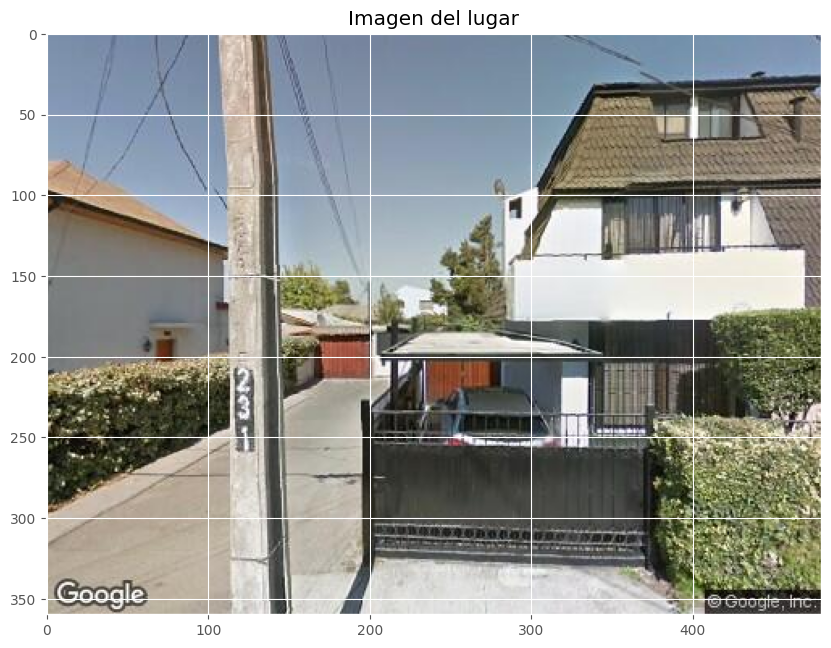

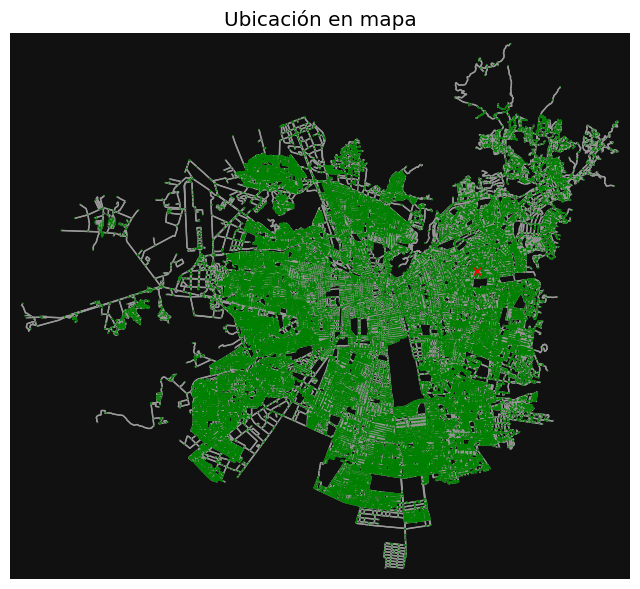

In [84]:
plot_image_in_map(G, df_nodos, dir_rar, 22354)

A continuación, se marcan en rojo todos los nodos que tienen asociada una imagen.

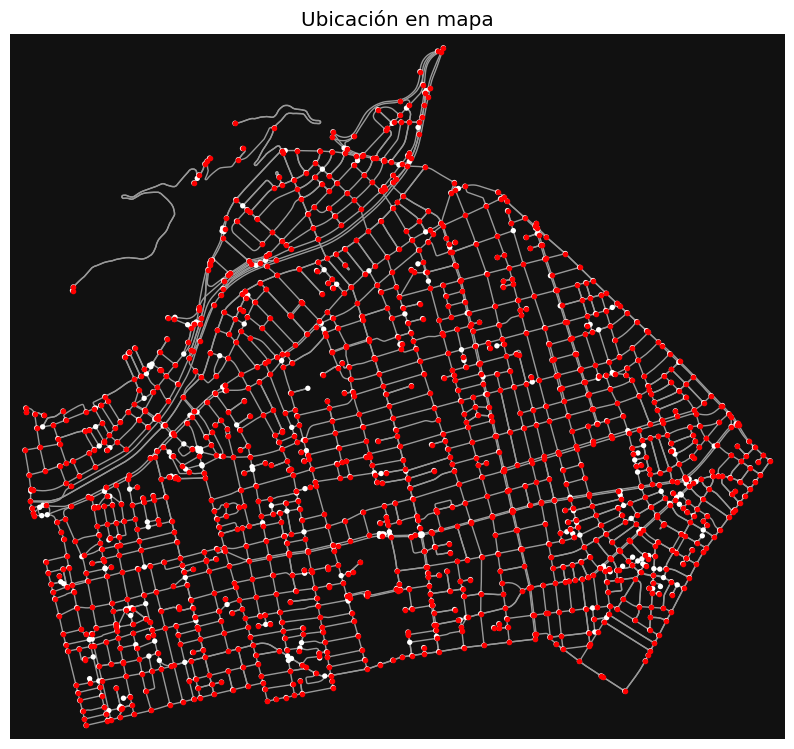

In [108]:
place = 'Providencia, Chile'
cf = '["highway"~"primary"]'
G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G, show=False, close = False, figsize=(10,10))

for i in range(len(df_nodos.x.tolist())):
  if str(df_nodos.nombre_foto[i]) != "nan": # Si es que hay una foto en el nodo
    lon = df_nodos.x.tolist()[i]
    lat = df_nodos.y.tolist()[i]
    ax.set_title("Ubicación en mapa")
    ax.plot(lon, lat, c='red', marker='.')

# Encontrar el nodo más cercano para todas las imagenes y los puntos de delitos

In [156]:
# Todas las comunas de santiago:

comunas = [
    "Santiago, Chile",
    "Conchalí, Chile",
    "Huechuraba, Chile",
    "Independencia, Chile",
    "Quilicura, Chile",
    "Recoleta, Chile",
    "Renca, Chile",
    "Las Condes, Chile",
    "Lo Barnechea, Chile",
    "Providencia, Chile",
    "Vitacura, Chile",
    "La Reina, Chile",
    "Macul, Chile",
    "Nunoa, Chile",
    "Penalolen, Chile",
    "La Florida, Chile",
    "La Granja, Chile",
    "El Bosque, Chile",
    "La Cisterna, Chile",
    "La Pintana, Chile",
    "San Ramon, Chile",
    "Lo Espejo, Chile",
    "Pedro Aguirre Cerda, Chile",
    # "San Joaquin, Chile", # No se encuentra en el mapa
    "San Miguel, Chile",
    "Cerrillos, Chile",
    "Estacion Central, Chile",
    "Maipu, Chile",
    "Cerro Navia, Chile",
    "Lo Prado, Chile",
    "Pudahuel, Chile",
    "Quinta Normal, Chile"
]

G = ox.graph_from_place(comunas, network_type='drive')

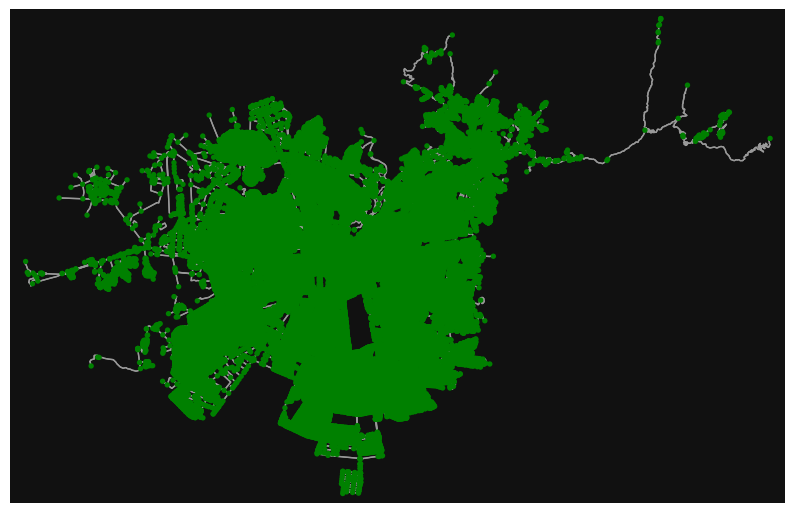

In [157]:
fig, ax = ox.plot_graph(G, show=False, node_color="green", node_size=15, close = False, figsize=(10,10))

In [191]:
# Encontrar el nodo más cercano a cada imagen

allpoints['nearest_node'] = allpoints.geometry.apply(lambda point: ox.distance.nearest_nodes(G, point.x, point.y) if not point.is_empty else None)

allpoints.nearest_node.value_counts()

KeyboardInterrupt: 

In [ ]:
for index, row in allpoints.iterrows():
    node_id = row['nearest_node']
    # Se asignan las variables percetuales a los nodos
    G.nodes[node_id]['nombre_foto'] = row['nombre_foto']

In [ ]:
gdf_nodes_imagenes, gdf_edges_imagenes = ox.convert.graph_to_gdfs(G)

In [ ]:
nodos_final = gdf_nodes_imagenes.reset_index()
aristas_final = gdf_edges_imagenes.reset_index()

In [ ]:
# Guardar nodos y aristas en csv

nodos_final.to_csv(os.path.join("output", "nodos_final_stgo.csv"),index=False)
aristas_final.to_csv(os.path.join("output", "aristas_final_stgo.csv"),index=False)

In [ ]:
df_nodos = pd.read_csv(os.path.join("output", "nodos_final_stgo.csv"))

df_nodos

In [ ]:
# Encontar el nodo más cercano a cada delito

gdf_delitos['nearest_node'] = gdf_delitos.geometry.apply(lambda point: ox.distance.nearest_nodes(G, point.x, point.y) if not point.is_empty else None)

gdf_delitos.nearest_node.value_counts()

In [ ]:
# Guardar delitos con su nodo más cercano en csv

gdf_delitos = gdf_delitos.reset_index()
gdf_delitos.to_csv(os.path.join("output", "delitos_stgo.csv"),index=False)